In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('../data/clean_data/df_sessions_w_feats.csv')
df.head()

,CR,is_organic,is_social_media_ad,in_app_browser,is_top_browser,is_popular_brand,utm_source_(not set),utm_source_aeiciopgciauosisathm,utm_source_ahgbtejtesiumjouidys,utm_source_akopqaqajrlgbjrrivph,...,geo_country_venezuela,geo_country_vietnam,geo_country_wallis & futuna,geo_country_yemen,geo_country_zimbabwe,utm_campaign_te,utm_keyword_te,geo_city_te,screen_width_std,screen_height_std
0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029096,0.024005,0.013889,-0.538619,-0.633628
1,0,0,0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010415,0.015396,0.031466,-0.493538,0.079150
2,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.029096,0.024005,0.024602,-0.538619,-0.633628
3,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036736,0.033880,0.031466,-0.479112,-0.282558
4,0,0,0,0,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036736,0.033880,0.031466,-0.479112,-0.282558


In [4]:
x = df.drop(['CR'], axis=1)
y = df['CR']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [17]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

TypeError: GradientBoostingClassifier.__init__() got an unexpected keyword argument 'class_weight'

In [39]:
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 1] = 25

# Train the model with sample weights
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(x_train, y_train, sample_weight=sample_weights)

GradientBoostingClassifier()

In [33]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    results = {}
    
    results['accuracy'] = accuracy_score(y_true, y_pred)
    
    results['f1_score'] = f1_score(y_true, y_pred)
    
    cm = confusion_matrix(y_true, y_pred)
    results['confusion_matrix'] = cm
    
    results['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"ROC-AUC Score: {results['roc_auc']:.4f}")
    
    return results

In [40]:
y_pred = gb_classifier.predict(x_test)
y_pred_prob = gb_classifier.predict_proba(x_test)[:, 1]

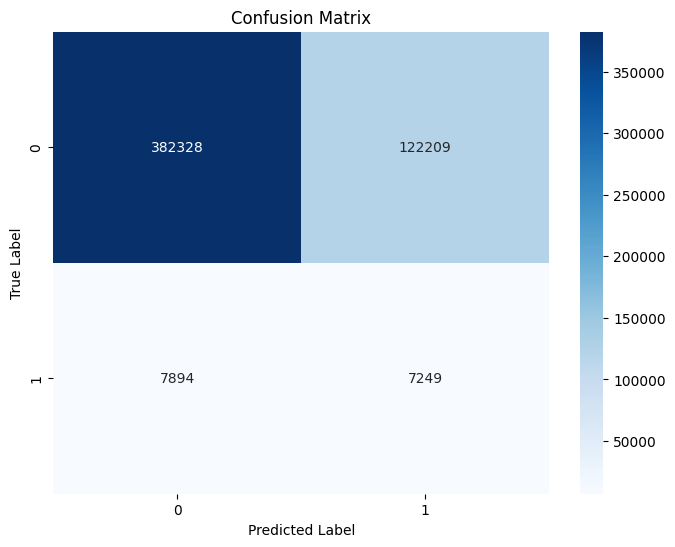

Accuracy: 0.7496
F1 Score: 0.1003
ROC-AUC Score: 0.6888


{'accuracy': 0.7496478602216748,
 'f1_score': 0.1002621005387238,
 'confusion_matrix': array([[382328, 122209],
        [  7894,   7249]]),
 'roc_auc': 0.6888359414181495}

In [41]:
evaluate_model(y_test, y_pred, y_pred_prob)

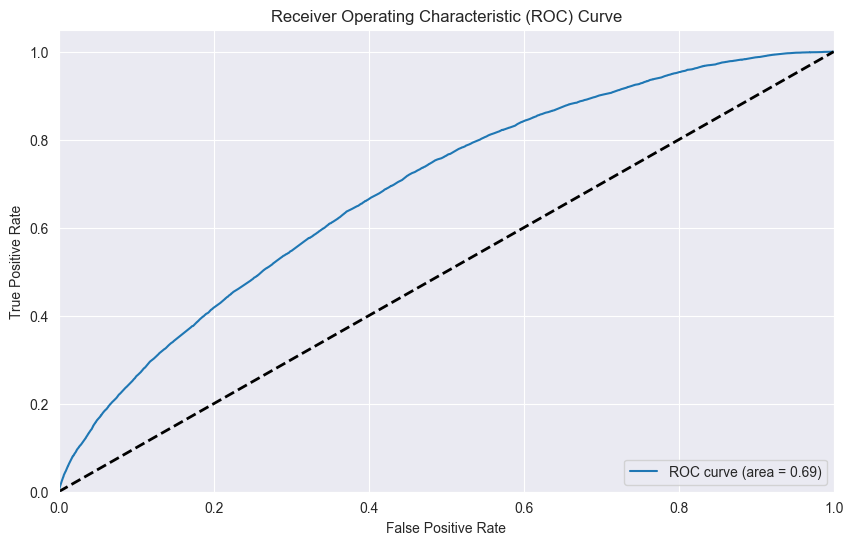

In [6]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()